# PART 1

### Question 1 
Join the House Prices - Advanced Regression Techniques competition on Kaggle. Download the
training and test data.

In [916]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# col_names = ["sepal length", "sepal width", "petal length", "petal width", "class"]
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [917]:
# helper plot function
def custom_plot(ax, xlab="", ylab="", title=""):
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)


### Question 2
Give 3 examples of continuous and categorical features in the dataset; choose one feature of each
type and plot the histogram to illustrate the distribution.

#### Continuous features:
- Lot Frontage
- Lot Area
- Sale Price

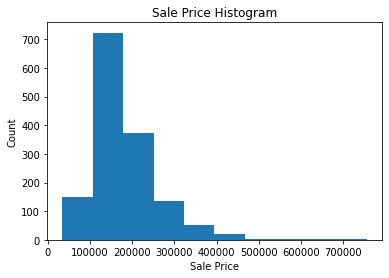

In [918]:
# Histogram for SalePrice
plt.hist(df_train["SalePrice"])
custom_plot(plt.gca(), xlab = "Sale Price", ylab = "Count", title = "Sale Price Histogram")




#### Categorical features:
- Street
- Lot Shape
- Utilities

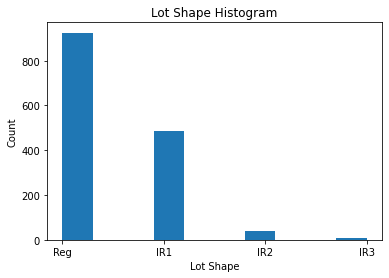

In [919]:
# Histogram for LotShape
plt.hist(df_train["LotShape"])
custom_plot(plt.gca(), xlab = "Lot Shape", ylab = "Count", title = "Lot Shape Histogram")

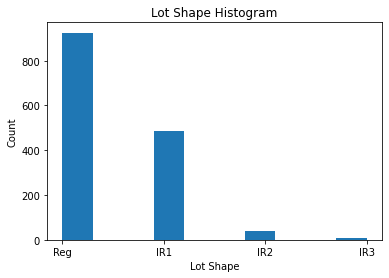

In [920]:
# Histogram for LotShape
fig, ax = plt.subplots(1, 1)
ax.hist(df_train["LotShape"])
custom_plot(ax, xlab = "Lot Shape", ylab = "Count", title = "Lot Shape Histogram")


- MSSubClass is the type of estate. I think it is important to predict cost but has too many types to be one hot encoded.
- MSZoning identifies type of zone in which the estate is located. Quite important for price, can assume five values: RL, RM, RH, FV, C. Candidate for 1HE
- Street is almost always "Pave", no information - can be thrown away.
- Alley: 1369 NaN on 1459 rows, no information - can be thrown away.
- LotShape: General shape, mostly regular or slightly irregular, very few moderate and irregular.
- LandContour: Flatness, almost all Level, some banked, hillside and depression (might be useless)
- Utilities: All AllPub, just useless 
- LotConfig: > 1000 Inside lots, some Corner lots and a few Cul de sac (might be useless)
- LandSlope: Almost all Gentle, throw away.
- Neighborhood: Many neighborohoods listed (25) data well distributed, so good but not feasible to 1HE.
- Condition1: Most Norm, maybe throw away.
- Condition2: Basicall all Norm, throw away.
- BldgType: Many single family detached, some townhouse end units, maybe keep, 5 values so possible 1HE
- HouseStyle: Most are One story, many two story and some 1.5finished and Split level, 8 values in total.
- OverallQual: Mostly slightly above average on 5s, 6s, 7s, some 8s and 4s very few lows and highs.
- OverallCond: Almost all 5 and above, a lot of 5s and some 6s and 7s.
- YearBuilt: Almost none <1900, general increasing trend, > 400 around 2000.
- YearRemodAdd: Quite a few arond 1950, then steady up to 2000 where increases massively with peak at 2010.
- RoofStyle: 90% Gable, 10% Hip, not much data here, other classes basically not represented.
- RoofMatl: Basically all Standard Composite shingle, can throw away.
- Exterior1st: lot of vinyl siding, some hardboard, brick face and wood siding. few asbestos shingles. Too many types.
- Exterior2nd: Most between vinyl, plywood and wood siding.
- MasVnrType: 800+ None, others mostly Brick face and some stone.
- ExterQual: 800+ Typical material quality of the exterior, almost all others Good. 
- ExterCond: 1200+ Typical, some good but I think throw away.
- Foundation: Mainly evenly divided into Poured Concrete and Cinder Block, Some Brick & Tile. Good candidate for 1HE
- BsmtQual: Mainly evenly divided into Good and Average, some Excellents.
- BsmtFinType2: Mostly Unfinished, can throw away.
- Heating: Almost all Gas forced warm air furnace, throw away.
- HeatingQC: 700+ Excellent, many average and some good.
- CentralAir: Mostly all yes, < 100 No. Can throw away.
- Electrical: Almost all Standard circuit breakers & romex, some Fuse box over 60 Amp. Throw.
- KitchenQual: Good number of goods and averages. some excellents and very few fair.
- Functional: Mostly all Typical, throw away.
- FirePlaceQu: Mostly NA, throw away
- GarageType: >800 Attached to home, quite a few detached, some builtin and NA.
- GarageFinish: Many Unfinished, quite a few Rough finished an finished, 81 NA.
- GarageQual: Almost all average, ignore.
- GarageCond: Almost all average, ignore.
- PavedDrive: Almost all yes, ignore.
- PoolQC: Basicall all NA, ignore.
- Fence: Most NA, ignore.
- MiscFeature: Almost all NA, just some sheds, ignore.
- SaleType: >1200 Warranty Deed, some New but little info, throw away.
- SaleCondition: Almost 1200 normal, some partial and abnormal. Maybe throw away?

### Question 3
Pre-process your data, explain your pre-processing steps, and the reasons why you need them.
(Hint: data pre-processing steps can include but are not restricted to: dealing with missing values,
normalizing numerical values, dealing with categorical values etc.)

In [921]:
len_train = len(df_train)
df = pd.concat([df_train, df_test])

In [922]:
columns_visually_useless = {'Id', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig', \
                  'LandSlope', 'Condition1', 'Condition2', 'RoofStyle', \
                  'RoofMatl', 'ExterCond', 'BsmtFinType2', 'Heating', 'CentralAir', \
                  'Electrical', 'Functional', 'FireplaceQu', 'GarageYrBlt', 'TotRmsAbvGrd'}
for col in df.columns:
    if df[col].isna().sum() / len(df) > 0.3 or col in columns_visually_useless:
        df.drop(columns=[col])

na_cols = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Electrical", \
           "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", \
           "Fence", "MiscFeature"]
for col in na_cols:
    df[col].fillna("NA", inplace = True)

df["MasVnrType"].fillna("None", inplace = True) # has 8 NaN and a defined "None" Category, cleanup.
df = df.interpolate()
df = pd.get_dummies(df)

In [923]:
df_train = df.iloc[:len_train, :]
df_test = df.iloc[len_train:, :]

### Question 4
One common method of pre-processing categorical features is to use a one-hot encoding (OHE).
Suppose that we start with a categorical feature xj
, taking three possible values: xj ∈ {R,G,B}. A
one-hot encoding of this feature replaces xj with three new features: xj R,xjG ,xj B . Each feature
contains a binary value of 0 or 1, depending on the value taken by xj
. For example, if xj = G, then
xjG = 1 and xj R = xj B = 0.
Give some examples of features that you think should use a one-hot encoding and explain why.
Convert at least one feature to a one-hot encoding (you can use your own implementation, or that
in pandas or scikit-learn) and visualize the results by plotting feature histograms of the original
feature and its new one-hot encoding.

### Question 5
Using ordinary least squares (OLS), try to predict house prices on this dataset. Choose the features
(or combinations of features) you would like to use or ignore, provided you justify your choice.
Evaluate your predictions on the training set using the MSE and the R
2
score. For this question,
you need to implement OLS from scratch without using any external libraries or packages.

In [924]:
cm = df_train.corr()

th_saleprice = 0.1
th_corr_pairs = 0.75

highly_corr_saleprice_bool = np.abs(cm.values) > th_saleprice
highly_corr_pairs_bool = np.abs(cm.values) > th_corr_pairs

high_corr_pairs = [(cm.columns[i], cm.columns[j]) for i, j in zip(*np.where(highly_corr_pairs_bool)) 
                 if i < j and cm.columns[j] != "SalePrice"] 
high_info_cols = {cm.columns[i] for i, j in zip(*np.where(highly_corr_saleprice_bool)) 
                 if i < j and cm.columns[j] == "SalePrice"}

for c1, c2 in high_corr_pairs:
    if c1 in high_info_cols and c2 in high_info_cols:
        high_info_cols.remove(c1)

df_train_processed = df_train[list(high_info_cols) + ["SalePrice"]]

In [925]:
class MyOLS:
    def __init__(self, X, Y):
        self._theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

    def predict(self, X_test):
        predictions = X_test.dot(self._theta_best)
        return predictions

In [926]:
Y = df_train_processed["SalePrice"]
X = df_train_processed.drop(columns=["SalePrice"])

ols = MyOLS(X, Y)
predictions = ols.predict(X)
predictions.to_csv('train_results.csv', sep=',', index=False)

In [927]:
def my_MSE(y, y_pred):
    return 0.5 * np.mean((y - y_pred) ** 2)
def my_RSquared(y, y_pred):
    return 1 - sum((y - y_pred) ** 2)/ sum((y - np.mean(y)) ** 2)

In [928]:
print("MSE: ", my_MSE(Y, predictions))
print("RSquared: ", my_RSquared(Y, predictions))


MSE:  647306406.6550049
RSquared:  0.794727095130888


### Question 6 
Train your model using all of the training data (all data points, but not necessarily all the features),
and test it using the testing data. Submit your results to Kaggle.

In [929]:
df_test_processed = df_test[high_info_cols]
test_predictions = ols.predict(df_test_processed)

pred_df = pd.DataFrame(test_predictions, columns = ['SalePrice'])
pred_df.reset_index(inplace=True)
pred_df = pred_df.rename(columns = {'index':'Id'})
pred_df["Id"] = pred_df["Id"].apply(lambda x : x + len(df_train) + 1)
pred_df.to_csv('results.csv', sep=',', index=False)